In [1]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2


from azure.quantum import Workspace 
from azure.quantum.qiskit import AzureQuantumProvider

import sys
import os

sys.path.append(os.path.abspath("..\\..\\.."))
from objects.FiveQbStabilizerCode import FiveQbStabilizerCodeCircuit
from functions import *


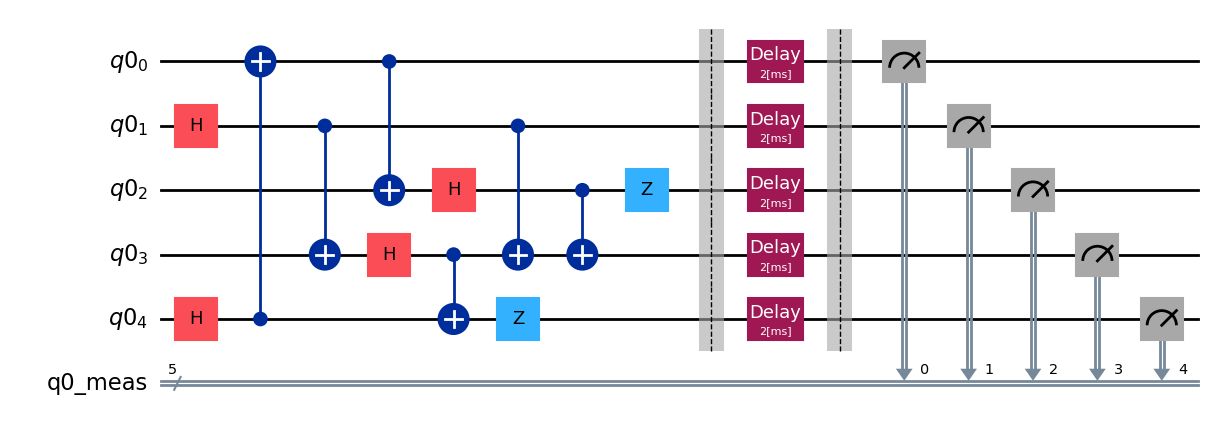

In [2]:


def load_circuit():
    qc = FiveQbStabilizerCodeCircuit(1)

    qc.encode(type='0')

    qc.delay(2, unit='ms')

    qc.measure_all()

    return qc

qc = load_circuit()
qc.draw('mpl')



In [3]:
# IonQ access
workspace = Workspace(  
    resource_id = "", # Add the resourceID of your workspace
    location = "" # Add the location of your workspace (for example "westus")
    )

provider = AzureQuantumProvider(workspace)

In [4]:
backend_name = "ionq.qpu.aria-1"
backend_name_simulator = "ionq.simulator"
backend = provider.get_backend(backend_name)
simulator_backend = provider.get_backend(backend_name_simulator)

option_params = {
    "error-mitigation": {
        "debias": False,
        "sharpen": False
    }
}

backend.options.update_options(**option_params)
simulator_backend.options.update_options(**option_params)
simulator_backend.options.update_options(noise_model="aria-1") 

In [5]:

phy_qc = qc.physical_circuit
isa_circuit = transpile(phy_qc, backend, optimization_level=3)
print(f"Circuit Depth: {qc.physical_circuit.depth()}")
# print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
# isa_circuit.draw(output='mpl')



Circuit Depth: 9


In [6]:
circuits = [isa_circuit]

In [7]:
simulation_result = sampler_simulation(qc.physical_circuit, 3200)

for lq in qc.qubits:
    # state = lq.qb_measure
    state = lq.qb_measures
    # state = lq.all_measures
    print(f"  {state.name}: {simulation_result.data[state.name].get_counts()}")


  q0_meas: {'01100': 208, '00110': 204, '11110': 207, '11000': 201, '00101': 181, '11101': 220, '01010': 161, '10100': 194, '11011': 205, '10001': 219, '00011': 212, '10010': 211, '01111': 213, '10111': 202, '00000': 194, '01001': 168}


Run experiment

In [ ]:
shots = 3200
# job = backend.run(circuits, shots=shots)
# # job = simulator_backend.run(circuits, shots=shots) # simulador
# job_id = job.id()
# # pub_result = job.result()
# print(f"Job ID: {job_id}")


Job ID: d33330dd-f6d2-11ef-99f5-3800255d459d


In [ ]:
results = extract_results_json_IONQ('5qb_stabilizer_T1_delay2ms.json', type='percentage', reverse_order=True)[0]
print(results)

{'00000': 6.660412757973734, '00001': 0.3439649781113196, '00010': 0.18761726078799248, '00011': 5.222013758599124, '00100': 0.18761726078799248, '00101': 5.409631019387117, '00110': 7.0356472795497185, '00111': 0.594121325828643, '01000': 0.3439649781113196, '01001': 6.378986866791744, '01010': 4.815509693558474, '01011': 0.3439649781113196, '01100': 4.971857410881801, '01101': 0.28142589118198874, '01110': 0.28142589118198874, '01111': 6.441525953721075, '10000': 0.2501563477173233, '10001': 6.910569105691057, '10010': 5.8786741713570985, '10011': 0.09380863039399624, '10100': 5.347091932457786, '10101': 0.2188868042526579, '10110': 0.31269543464665417, '10111': 5.409631019387117, '11000': 6.941838649155723, '11001': 0.6253908692933083, '11010': 0.06253908692933083, '11011': 5.284552845528456, '11100': 0.28142589118198874, '11101': 5.72232645403377, '11110': 6.629143214509068, '11111': 0.5315822388993121}


In [14]:
states = [bin(i)[2:].zfill(5) for i in range(2**5)]
valid_states = [s for s in states if sum([int(i) for i in s]) % 2 == 0]

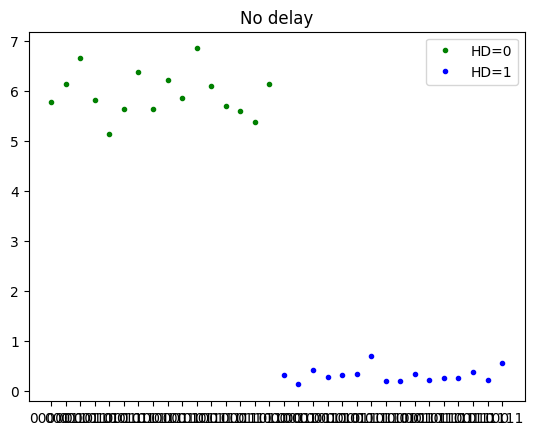

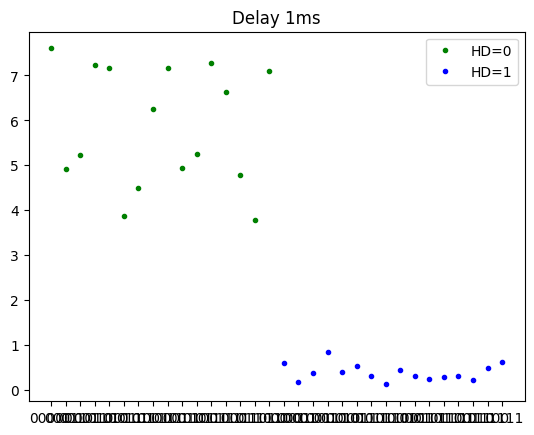

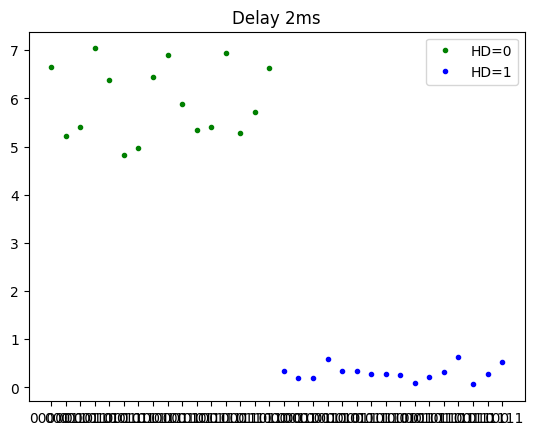

In [ ]:
results_no_delay = extract_results_json_IONQ('5qb_stabilizer_T1_all_meas.json', type='percentage', reverse_order=True)[0]
results_delay1 = extract_results_json_IONQ('5qb_stabilizer_T1_delay1ms.json', type='percentage', reverse_order=True)[0]
plot_results_hamming_distance(results_no_delay, 5, valid_states, title='No delay')
plot_results_hamming_distance(results_delay1, 5, valid_states, title='Delay 1ms')
plot_results_hamming_distance(results, 5, valid_states, title='Delay 2ms')

In [16]:
print(np.mean([
    value for key, value in results_no_delay.items() if key in valid_states
]))
print(np.mean([
    value for key, value in results_no_delay.items() if key not in valid_states
]))
print('snr:', np.mean([
    value for key, value in results_no_delay.items() if key in valid_states
])/np.mean([
    value for key, value in results_no_delay.items() if key not in valid_states
])
)

5.933494842138168
0.3165051578618318
snr: 18.74691358024691


In [17]:
print(np.mean([
    value for key, value in results_delay1.items() if key in valid_states
]))
print(np.mean([
    value for key, value in results_delay1.items() if key not in valid_states
]))
print('snr:', np.mean([
    value for key, value in results_delay1.items() if key in valid_states
])/np.mean([
    value for key, value in results_delay1.items() if key not in valid_states
])
)

5.855222013758599
0.39477798624140087
snr: 14.831683168316832


In [18]:
print(np.mean([
    value for key, value in results.items() if key in valid_states
]))
print(np.mean([
    value for key, value in results.items() if key not in valid_states
]))
print('snr:', np.mean([
    value for key, value in results.items() if key in valid_states
])/np.mean([
    value for key, value in results.items() if key not in valid_states
])
)

5.941213258286429
0.30878674171357096
snr: 19.240506329113927


TVD

In [19]:
tvd_no_delay = calculate_tvd(results_no_delay, generate_uniform_distribution(5, valid_states), percentage=True)
tvd_delay1 = calculate_tvd(results_delay1, generate_uniform_distribution(5, valid_states), percentage=True)
tvd = calculate_tvd(results, generate_uniform_distribution(5, valid_states), percentage=True)

print("Total Variation Distance")
print(f"no delay:\t{round(tvd_no_delay*100,2)}%")
print(f"delay 1ms:\t{round(tvd_delay1*100,2)}%")
print(f"delay 2ms:\t{round(tvd*100,2)}%")

Total Variation Distance
no delay:	6.2%
delay 1ms:	12.73%
delay 2ms:	8.19%
